In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model and reflect tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#take a look at the columns of the measurement table

first_row_m = session.query(measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x238c6085f40>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [10]:
#take a look at the columns of the station table

first_row_s = session.query(station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x238c60a6130>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'id': 1,
 'latitude': 21.2716}

In [11]:
# Find the most recent date in the data set
from sqlalchemy import desc
most_recent = session.query(measurement).order_by(desc('date')).first().__dict__
most_recent

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x238c60a64f0>,
 'prcp': 0.0,
 'station': 'USC00519397',
 'tobs': 81.0,
 'date': '2017-08-23',
 'id': 2724}

In [12]:
# Retrieve last year of data from most recent data point
# Perform a query to retrieve the data and precipitation scores

last_year_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= '2016-08-23').\
        filter(measurement.date <= '2017-08-23').all()


In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(last_year_precip, columns=['Date', 'Precipitation'])
precip_df = precip_df.set_index('Date')
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [14]:
# Sort the dataframe by date
precip_df = precip_df.sort_index()
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


<AxesSubplot:xlabel='Date'>

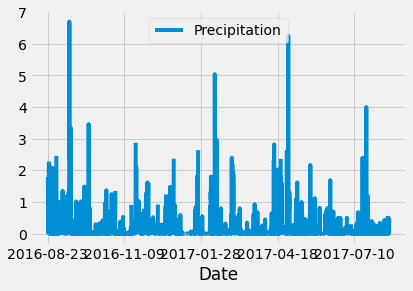

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station).count()
print(f'There are {total_stations} total stations.')

There are 9 total stations.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
recordCount, stationName, stationID = [], [], []

for place in session.query(station).all():
    results = session.query(measurement).filter(measurement.station == place.station).count()
    print(f'There are {results} records for Station {place.name}.')
    recordCount.append(results)
    stationName.append(place.name)
    stationID.append(place.station)

recordsDF = pd.DataFrame({
    'Station': stationName,
    'Station ID': stationID,
    'Total Records': recordCount
})
recordsDF = recordsDF.sort_values('Total Records', ascending=False)
recordsDF
    # to display in descending order I would load each one into a list or dict during the loop and then sort that

There are 2724 records for Station WAIKIKI 717.2, HI US.
There are 2709 records for Station KANEOHE 838.1, HI US.
There are 2202 records for Station KUALOA RANCH HEADQUARTERS 886.9, HI US.
There are 1372 records for Station PEARL CITY, HI US.
There are 511 records for Station UPPER WAHIAWA 874.3, HI US.
There are 2669 records for Station WAIMANALO EXPERIMENTAL FARM, HI US.
There are 2772 records for Station WAIHEE 837.5, HI US.
There are 1979 records for Station HONOLULU OBSERVATORY 702.2, HI US.
There are 2612 records for Station MANOA LYON ARBO 785.2, HI US.


,Station,Station ID,Total Records
6,"WAIHEE 837.5, HI US",USC00519281,2772
0,"WAIKIKI 717.2, HI US",USC00519397,2724
1,"KANEOHE 838.1, HI US",USC00513117,2709
5,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
8,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
2,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
7,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
3,"PEARL CITY, HI US",USC00517948,1372
4,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

active = session.query(measurement).filter(measurement.station == 'USC00519281')
tempsum=0
# there is no .sum()??? 
for row in active:
    tempsum = tempsum + float(row.tobs)

maxtemp = active.order_by(desc('tobs')).first().tobs
mintemp = active.order_by('tobs').first().tobs
avgtemp = tempsum / active.count()

print(f'''
Minimum temp: {mintemp}
Maximum temp: {maxtemp}
Average temp: {round(avgtemp,1)}''')


Minimum temp: 54.0
Maximum temp: 85.0
Average temp: 71.7


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent = active.order_by(desc('date')).first().date
recent

'2017-08-18'

In [21]:
temprange = session.query(measurement.date, measurement.tobs).filter(measurement.date >= '2016-08-18').\
        filter(measurement.date <= '2017-08-18').all()

In [22]:
tempDF = pd.DataFrame(temprange, columns=['Date', 'Temp'])
tempDF = tempDF.set_index('Date')

<AxesSubplot:ylabel='Frequency'>

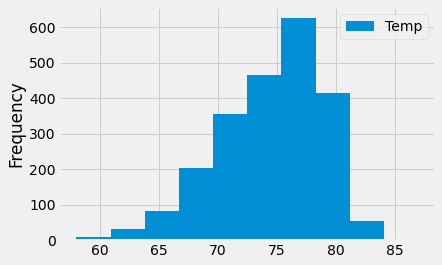

In [23]:
tempDF.plot.hist()

# Close session

In [24]:
# Close Session
session.close()